In [ ]:
# Import helper libraries
import numpy as np # Numerical algorithms
import pandas as pd # Library for data processing
import ast # Abstract syntax trees
import random # Random number utility


import matplotlib.pyplot as plt # Visualisation

# Machine learning
from sklearn.model_selection import train_test_split
import torch

# Imports from model_builder
from model_builder import create_model, train_model
from analysis_utilities import show_prediction
from analysis_utilities import category_predictions
from analysis_utilities import model_evaluation

# Import image processing utilities
import sys
sys.path.insert(0, '../modules')
from image_utilities import convert_drawing_to_np_raw
from image_utilities import convert_PIL_to_np
from image_utilities import convert_np_to_PIL
from image_utilities import rotate
from image_utilities import flip
from image_utilities import enrich_images

N_CHUNKS = 1200


Download train_simplified data from https://www.kaggle.com/competitions/quickdraw-doodle-recognition/data?select=

Load data for selected category drawings

In [ ]:

CATEGORY_LABEL_DICT = {0: 'eye', 1: 'birthday cake', 2: 'sword', 3: 'clock', 4: 'umbrella',
              5: 'snowman', 6: 'cup', 7: 'bowtie', 8: 'fish', 9: 'flamingo', 10: 'star', 11: 'windmill'}

cat_labels = CATEGORY_LABEL_DICT.values()

# Load drawings for each category
category_drawings = {}
for label in cat_labels:
    data = pd.read_csv("../train_simplified/" + label + ".csv")
    category_drawings[label] = data

Create simplified images by shrinking them to 28x28 greyscale images.

In [ ]:
#  Dictionary containing categories as keys and drawings as values
drawings_dict = {}
for label in cat_labels:
    drawings = category_drawings[label][:5000]
    np_drawings = [convert_drawing_to_np_raw(ast.literal_eval(img), 256, 256).reshape(1, 784) for img in drawings['drawing'].values]
    drawings_dict[label] = np_drawings
    
# Concatenate to create X (values) and y (cat_labels)
X = []
y = []

for key, label in CATEGORY_LABEL_DICT.items():
    data_i = drawings_dict[label]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
    
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

Generate grid of random drawings from dataset.

In [ ]:
def grid_images(X, y):
  
    fig, axs = plt.subplots(12, 12, figsize=(20,20))
    
    for label_num in range(0,144):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  # resize images
        i = label_num // 12
        j = label_num % 12
        axs[i,j].imshow(image)
        axs[i,j].axis('off')
        axs[i,j].set_title(CATEGORY_LABEL_DICT[y[r_label]])

    plt.show()

In [ ]:
grid_images(X, y)

In [ ]:
def plot_accuracy(input_size, output_size, hidden_sizes, np_train, np_labels, y_train, np_test,
    y_test, learning_rate = 0.003, weight_decay = 0.0, dropout = 0.0, n_chunks = N_CHUNKS, optimiser = 'SGD'):
   
    train_accuracy = []
    test_accuracy = []

    for epochs in np.arange(10, 60, 10):
        model = create_model(input_size, output_size, hidden_sizes, dropout = dropout) # Create model
        train_model(model, np_train, np_labels, epochs = epochs, n_chunks = n_chunks,
             learning_rate = learning_rate, weight_decay = weight_decay, optimiser = optimiser) # Fit model
        train_acc, test_acc = model_evaluation(model, np_train, y_train, np_test, y_test)  # Get accuracy
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
    
    return train_accuracy, test_accuracy

Test the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1) # Dataset is split into the training and testing data

In [ ]:
# Tensors
np_train = torch.from_numpy(X_train).float()
np_labels = torch.from_numpy(y_train).long()
np_test = torch.from_numpy(X_test).float()
# np_test_labels = torch.from_numpy(y_test).long()

# Hyperparameters selected
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 12

dropout = 0.0
weight_decay = 0.0
n_chunks = N_CHUNKS
learning_rate = 0.03
optimiser = 'SGD'

Fit the model

In [ ]:
train_accuracy, test_accuracy = plot_accuracy(input_size, output_size,
    hidden_sizes, np_train, np_labels, y_train, np_test, y_test, learning_rate = learning_rate,
    dropout = dropout, weight_decay = weight_decay, n_chunks = n_chunks, optimiser = optimiser)

In [ ]:
def plot_curve(train_accuracy, learning_rate):
    x = np.arange(10, 10 * (len(train_accuracy) + 1), 10)
    plt.plot(x, train_accuracy)
    plt.plot(x, test_accuracy)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Accuracy', fontsize=11)
    plt.show()

In [ ]:
plot_curve(train_accuracy, learning_rate)

Variance in train and test curve suggests more data is required. I will increase data exported and manipulate these (rotation and reflection) to generate more data.

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(8,4))

np_img = X[0]
np_img_flipped = convert_PIL_to_np(flip(convert_np_to_PIL(np_img, 28, 28)), 28, 28)
np_img_rotated = convert_PIL_to_np(rotate(convert_np_to_PIL(np_img, 28, 28)), 28, 28)

# Original image
axs[0].set_title('original image')
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

# Reflected image
axs[1].set_title('flipped image')
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

# Rotated image
axs[2].set_title('rotated image')
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')

OPTIONAL: The following process takes over an hour 

In [ ]:
X_train, y_train = enrich_images(X_train, y_train, 784)

In [ ]:
np_train = torch.from_numpy(X_train).float() 
np_labels = torch.from_numpy(y_train).long()

# Fitting the model with new generated images
train_accuracy, test_accuracy = plot_accuracy(input_size, output_size, hidden_sizes, np_train, np_labels, y_train, np_test, y_test, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = N_CHUNKS, optimiser = optimiser)

In [ ]:
plot_curve(train_accuracy, learning_rate)

Further reduce variance by adding droput to the hidden layers and using adam optimiser to speed calculations.

In [18]:
# Fit model
train_accuracy, test_accuracy = plot_accuracy(input_size, output_size, hidden_sizes, np_train, np_labels, y_train, np_test, y_test, learning_rate = learning_rate, dropout = 0.2, weight_decay = weight_decay, n_chunks = N_CHUNKS, \
                                          optimiser = 'Adam')

Fitting model with epochs = 10, learning rate = 0.03

Epoch - 1/10   Loss - 1.3432
Epoch - 1/10   Loss - 1.0229
Epoch - 1/10   Loss - 0.9869
Epoch - 1/10   Loss - 0.9202
Epoch - 1/10   Loss - 0.8644
Epoch - 1/10   Loss - 0.8669
Epoch - 1/10   Loss - 0.8241
Epoch - 1/10   Loss - 0.7793
Epoch - 1/10   Loss - 0.8184
Epoch - 1/10   Loss - 0.7455
Epoch - 1/10   Loss - 0.7782
Epoch - 1/10   Loss - 0.7821
Epoch - 2/10   Loss - 0.6644
Epoch - 2/10   Loss - 0.6553
Epoch - 2/10   Loss - 0.6611
Epoch - 2/10   Loss - 0.6493
Epoch - 2/10   Loss - 0.6535
Epoch - 2/10   Loss - 0.6712
Epoch - 2/10   Loss - 0.6477
Epoch - 2/10   Loss - 0.6644
Epoch - 2/10   Loss - 0.6591
Epoch - 2/10   Loss - 0.6400
Epoch - 2/10   Loss - 0.6782
Epoch - 2/10   Loss - 0.6720
Epoch - 3/10   Loss - 0.5183
Epoch - 3/10   Loss - 0.5811
Epoch - 3/10   Loss - 0.6020
Epoch - 3/10   Loss - 0.5656
Epoch - 3/10   Loss - 0.5600
Epoch - 3/10   Loss - 0.5690
Epoch - 3/10   Loss - 0.5719
Epoch - 3/10   Loss - 0.5659
Epoch - 3/10   Los

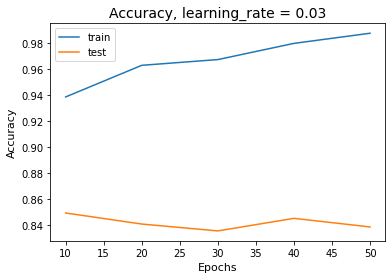

In [19]:
plot_curve(train_accuracy, learning_rate)

Use more training data and use more epochs to increase model accuracy. I experienced computational limitations.

In [20]:
def check_model_prediction(model, img, cat_labels):

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    predictions = category_predictions(model, img)
    show_prediction(img.resize_(1, 28, 28), predictions, cat_labels)
   

Build the model

In [21]:
model = create_model(input_size, output_size, hidden_sizes, dropout = dropout) 

dict_values(['eye', 'birthday cake', 'sword', 'clock', 'umbrella', 'snowman', 'cup', 'bowtie', 'fish', 'flamingo', 'star', 'windmill'])


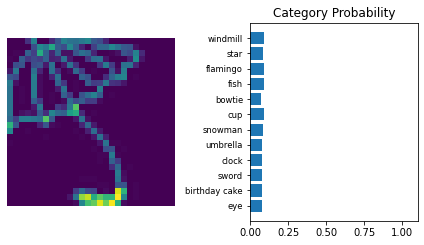

In [22]:
print(cat_labels)

model.eval() # turn off batch normalization

check_model_prediction(model, np_test[1], cat_labels) # get prediction for  image from  test dataset